# Summarization trials

## Setup

### Imports

In [ ]:
from typing import List, Optional, Union, Any, Tuple
import sys
from loguru import logger
from pathlib import Path 

import numpy as np
import pandas as pd
import plotly.express as px
import torch
import umap
import yaml, json
from langchain import HuggingFaceHub, LLMChain, PromptTemplate
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.chains import MapReduceDocumentsChain, ReduceDocumentsChain
from langchain.chains.combine_documents.stuff import StuffDocumentsChain
from langchain.schema.document import Document
from langchain.text_splitter import CharacterTextSplitter
from rich import print
from sklearn.cluster import KMeans, HDBSCAN, DBSCAN

from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
)

In [ ]:
sys.path.append("../")
from src.ai_news_digest.utils import check_gpu_availability, create_run_folder
from src.ai_news_digest.steps.benchmark import entropy

### GPU availability

In [ ]:
device = check_gpu_availability()

### Load secrets

In [ ]:
with open("../conf/local/credentials.yml", "r") as f:
    hf_secrets = yaml.load(f, Loader=yaml.SafeLoader)["hugging_face"]
hf_hub_token = hf_secrets["hf_hub_token"]

### Config

In [ ]:
PATH_INFO_DICT = "../data/03_primary/arxiv_dict_2023-11-06_00-22-42.json"
MODEL_KWARGS = {"device": device}
MODEL_ID = "BAAI/bge-small-en"
ENCODE_KWARGS = {
    "normalize_embeddings": True,
    "batch_size": 16,
    "output_value": "sentence_embedding",
    "convert_to_numpy": True,
    "show_progress_bar": True,
}
UMAP_KWARGS = {
    "n_neighbors": 4,
    "min_dist": 0.05,
    "n_components": 2,
    "metric": "cosine",
}
CLUSTERING_KWARGS = {    
    "min_cluster_size": 5, 
    "min_samples": 3, 
    "max_cluster_size": 30, 
    "cluster_selection_epsilon": 0.05,
}

## Load data

In [ ]:
# compute paths
info_path = Path(PATH_INFO_DICT)

# load data (original & translated)
with open(info_path, "r") as f:
    info_dict = json.load(f)["results"]
logger.info(f"Successfully loaded prepared data from : {info_path}")

# retrieve abstracts, titles, dates & paper IDs
df_data = pd.DataFrame(info_dict).transpose()

# display
df_data.head()

## Clusterize data

In [ ]:
def clustering_pipeline(
    df_embed: pd.DataFrame,
    umap_kwargs: dict,
    clustering_kwargs: Optional[dict]=None,
    random_state: int=123,
    df_data: Optional[pd.DataFrame]=None,
) -> Tuple[pd.DataFrame, Any]:
    
    #--- dimensionality reduction ---

    # instanciate umap projector
    reducer = umap.UMAP(random_state=random_state, **umap_kwargs)

    # project data
    umap_proj = reducer.fit_transform(df_embed)

    # normalize umap coords
    umap_proj = (umap_proj - umap_proj.min(axis=0)) / (umap_proj.max(axis=0) - umap_proj.min(axis=0))

    # store in a dataframe
    df_umap = pd.DataFrame(columns=[f"umap_{i}" for i in range(umap_proj.shape[1])], data=umap_proj)

    # add metadata if available
    if df_data is not None:
        df_umap = pd.concat((df_umap, df_data.reset_index(names=["ID"])), axis=1)

    #--- clustering ---
    if clustering_kwargs is not None:
        X_cluster = df_umap[[col for col in df_umap.columns if "umap" in col]]
        clustering = HDBSCAN(**clustering_kwargs)
        clustering.fit(X_cluster)
        df_umap["cluster"] = [str(elt) for elt in clustering.labels_]
        df_umap["noise"] = [int(elt==-1) for elt in clustering.labels_]

    #--- result ---
    return df_umap, clustering

In [ ]:
# load model
hf = HuggingFaceEmbeddings(
    model_name=MODEL_ID,
    model_kwargs={"device": "cpu"},
    encode_kwargs=ENCODE_KWARGS,
)

In [ ]:
# compute embeddings
embeddings = np.array(hf.embed_documents(df_data["abstract"]))

# store embeddings in a dataframe
df_embed = pd.DataFrame(
    data=embeddings, 
    columns=[f"embed_{i}" for i in range(embeddings.shape[1])],
    index=df_data.index
)

# display
df_embed.head()

In [ ]:
df_umap, clustering = clustering_pipeline(
    df_embed,
    UMAP_KWARGS,
    CLUSTERING_KWARGS,
    random_state=123,
    df_data=df_data,
)

In [ ]:
df_umap["cluster"] = [str(elt) for elt in clustering.labels_]
df_umap["noise"] = [int(elt==-1) for elt in clustering.labels_]
fig = px.scatter(
    df_umap,
    x="umap_0",
    y="umap_1",
    hover_data=[
        "title",
        "ID",
    ],
    color="cluster",
    symbol="noise",
    # color_continuous_scale=px.colors.qualitative.D3,
    category_orders={"cluster": list(np.sort(pd.unique(clustering.labels_)).astype(str))},
)
fig.show()

In [ ]:
df_umap.head(3)

## Summarize a cluster

### Choose one cluster

In [ ]:
# choose one cluster
cluster_idx = str(2)

# retrieve data from chosen cluster
df_cluster = df_umap.query("cluster==@cluster_idx").copy()
print(f"Size of cluster n°{cluster_idx}: {df_cluster.shape[0]}")
df_cluster.head(3)

### Load a model

In [ ]:
from langchain_community.llms import HuggingFacePipeline
from transformers import pipeline

model_kwargs = {
    "temperature": 0.8,
    "do_sample": True,
    "device": device,
    "torch_dtype": torch.bfloat16,
}


In [ ]:
# import torch
# from transformers import pipeline

# # pipe = pipeline("text-generation", model="stabilityai/stablelm-zephyr-3b", trust_remote_code=True, **model_kwargs)
# # pipe = pipeline(model="databricks/dolly-v2-3b", torch_dtype=torch.bfloat16, trust_remote_code=True, device_map="auto")
# # pipe = pipeline("text-generation", model="Writer/camel-5b-hf")
# # pipe = pipeline("text-generation", model="mistralai/Mistral-7B-v0.1", max_new_tokens=250, **model_kwargs)
# pipe = pipeline("text-generation", model="mistralai/Mistral-7B-Instruct-v0.2", max_new_tokens=250, **model_kwargs)

# hf = HuggingFacePipeline(pipeline=pipe)

In [ ]:
# # try model/pipeline inference with the `generate` method
# hf.pipeline.max_new_tokens = 20
# gen = hf.generate(
#     ["[INST] Tell me who you are. Answer in less than 50 words.[/INST]"], 
# )
# print(gen)

In [ ]:
# try model/pipeline inference with the `predict` method
prompt = "<s>[INST]Tell me who you are. Answer in less than 50 words.[/INST]"

pred = hf.predict(
    prompt, 
)
print(pred)

In [ ]:
hf.get_num_tokens(pred), len(pred.split(" "))

In [ ]:
from langchain_community.llms import VLLMOpenAI
import torch
from transformers import pipeline

llm = VLLMOpenAI(
    openai_api_key="EMPTY",
    openai_api_base="http://localhost:8000/v1",
    model_name="mistralai/Mistral-7B-Instruct-v0.2",
    # model_kwargs={"stop": ["."]},
    # model_kwargs=model_kwargs,
)
# print(llm.invoke("Rome is"))

In [ ]:
prompt = "<s>[INST]Tell me who you are. Answer in less than 50 words.[/INST]"

pred = llm.predict(
    prompt, 
)
print(pred)

In [ ]:
gen = llm.generate(
    ["[INST] Tell me who you are. Answer in less than 50 words.[/INST]"], 
)
print(gen)

In [ ]:
llm.get_num_tokens(pred), len(pred.split(" "))

In [ ]:
llm.get_num_tokens(pred)

### Stuffing

In [ ]:
df_cluster.shape

In [ ]:
from langchain.chains.summarize import load_summarize_chain
from langchain_community.document_loaders import WebBaseLoader
from langchain.schema.document import Document


docs = [
    Document(
        page_content=f"Article n°{i} -- {row['abstract']}",
        metadata=row.to_dict(),
    )
    for i, row in df_cluster.iterrows()
]

In [ ]:
# Define prompt
prompt_template = """<s>[INST]You will be provided with a list of scientific paper abstracts that you must summarize.
Write a concise summary focusing on the theme that is common to all papers and covers all of them.
Here is the list of abtracts:
"{text}"
CONCISE SUMMARY: [/INST]"""
prompt = PromptTemplate.from_template(prompt_template)

# Define LLM chain
llm_chain = LLMChain(llm=llm, prompt=prompt)

# Define StuffDocumentsChain
stuff_chain = StuffDocumentsChain(llm_chain=llm_chain, document_variable_name="text")

print(stuff_chain.run(docs))

In [ ]:
print(
    stuff_chain.prompt_length(docs=docs),
    llm.get_num_tokens("\n\n".join(df_cluster.abstract.values.tolist())) + llm.get_num_tokens(prompt_template),
    # stuff_chain._get_inputs(docs=docs),
)

In [ ]:
# hf.pipeline.tokenizer.model_max_length

In [ ]:
len(" ".join(df_cluster.abstract.values.tolist()))

In [ ]:
llm.get_num_tokens(" ".join(df_cluster.abstract.values.tolist()))

In [ ]:
# hf.get_num_tokens((" ".join(df_cluster.abstract.values.tolist())+" ")*16 )

In [ ]:
# hf.predict((" ".join(df_cluster.abstract.values.tolist())+" ")*16 )

In [ ]:
print(df_cluster.abstract.values.tolist())

Raw stuffing took 5min for cluster n°5
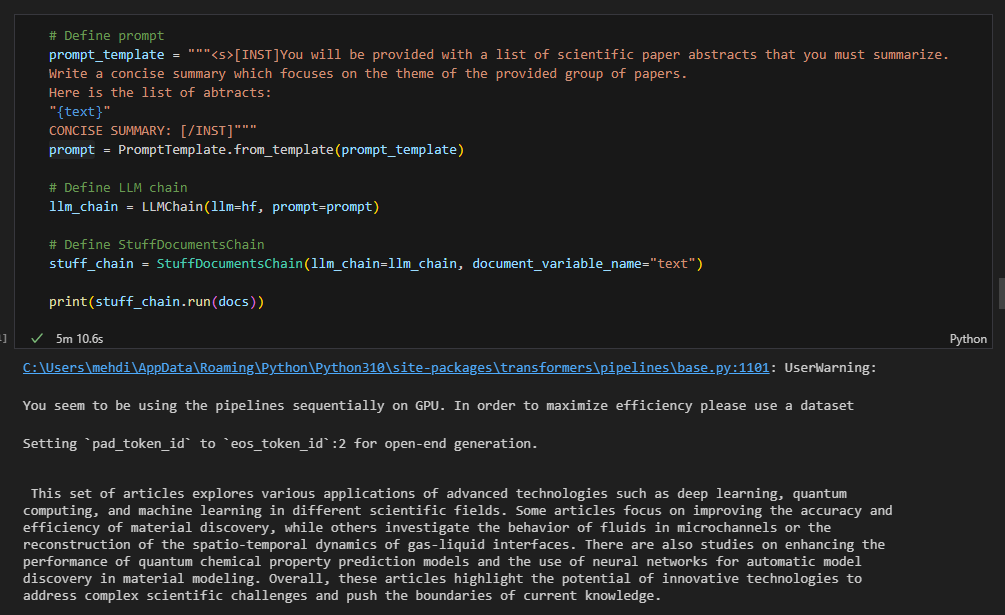

### [WIP] Resursive adaptive-window stuffing

In [ ]:
df_cluster = df_umap.query("cluster=='5'").copy()
print(f"Size of cluster n°{cluster_idx}: {df_cluster.shape[0]}")
df_cluster.head(2)

In [ ]:
prompt

In [ ]:
prompt_template

In [ ]:
def summarize_recurse(
    hf_pipe: HuggingFacePipeline, 
    prompt_template: str,
    docs: List[Document],
) -> str:
    
    # define Stuff chain
    prompt = PromptTemplate.from_template(prompt_template)
    llm_chain = LLMChain(llm=hf_pipe, prompt=prompt)
    stuff_chain = StuffDocumentsChain(llm_chain=llm_chain, document_variable_name="text")

    # TODO: sort documents based on their distance to O (origin)


    # get max sequence length OR force a specific value
    # TODO: check this value is valid and functional 
    # --> https://github.com/huggingface/transformers/blob/f1cc6157210abd9ea953da097fb704a1dd778638/src/transformers/models/mistral/configuration_mistral.py#L63 
    Lt_max = 6000

    # compute number of promt tokens
    Lt_prompt = hf_pipe.get_num_tokens(prompt_template)

    # compute nmber of tokens for docs
    Lt_docs_list = [hf_pipe.get_num_tokens(doc.page_content) for doc in docs]
    Lt_docs = np.sum(Lt_docs_list)
    
    # end case
    # TODO: check if this context_length is valid
    # if Lt_docs + Lt_prompt <= Lt_max:
    if stuff_chain.prompt_length(docs=docs) <= Lt_max:
        return stuff_chain.run(docs)
    
    else:

        news_docs = []
        j1, j2 = 0, 1

        while j1 < len(docs) and j2 < len(docs):

            if stuff_chain.prompt_length(docs=docs[j1:j2+1]) > Lt_max:
                news_docs.append(Document(page_content=stuff_chain.run(docs[j1:j2])))
                j1 = j2
                j2 = j2 + 1
            else:
                j2 = j2 + 1
        
        if j2 >= len(docs):
            news_docs.append(Document(page_content=stuff_chain.run(docs[j1:])))

        return summarize_recurse(hf_pipe, prompt_template, news_docs)
    

In [ ]:
summary = summarize_recurse(hf, prompt_template, docs)
print(summary)

In [ ]:
len(docs)

In [ ]:
print(hf.pipeline.model.config)